In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import missingno as msno
import plotly.express as px  # For interactive plots
from scipy import stats
from pathlib import Path
import numpy as np 
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')


In [2]:
generation_df = pd.read_csv("Total_Energy_Generation_by_State_and_Year.csv")
generation_df

,Date,State,State code,State type,Category,Subcategory,Energy Source,Unit,Total Energy Generation,Year,...,Wind_YoY_Absolute_Change,Fossil_YoY_Percent_Change,Hydro_YoY_Percent_Change,Renewables_YoY_Percent_Change,Solar_YoY_Percent_Change,Wind_YoY_Percent_Change,YoY absolute change,YoY % change,Country,Country code
0,2001-01-01,Alabama,AL,state,Electricity generation,Total,Total Generation,GWh,11328.07,2001,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,United States of America,USA
1,2002-01-01,Alabama,AL,state,Electricity generation,Total,Total Generation,GWh,11221.92,2002,...,0.00,-4.539781,30.371878,18.943800,0.000000,0.000000,-106.15,-0.937053,United States of America,USA
2,2003-01-01,Alabama,AL,state,Electricity generation,Total,Total Generation,GWh,12000.45,2003,...,0.00,13.967982,2.228997,-3.809573,0.000000,0.000000,778.53,6.937583,United States of America,USA
3,2004-01-01,Alabama,AL,state,Electricity generation,Total,Total Generation,GWh,11709.16,2004,...,0.00,-6.662454,7.964173,6.071039,0.000000,0.000000,-291.29,-2.427326,United States of America,USA
4,2005-01-01,Alabama,AL,state,Electricity generation,Total,Total Generation,GWh,12094.66,2005,...,0.00,4.822089,3.064219,2.675419,0.000000,0.000000,385.50,3.292294,United States of America,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15450,2020-12-01,Wyoming,WY,state,Electricity generation,Total,Total Generation,GWh,4234.26,2020,...,678.85,-10.550162,34.787215,165.722400,29.032258,188.553732,333.28,8.543494,United States of America,USA
15451,2021-12-01,Wyoming,WY,state,Electricity generation,Total,Total Generation,GWh,4063.86,2021,...,276.68,-13.465747,-36.027774,22.139097,-7.894737,26.632527,-170.40,-4.024316,United States of America,USA
15452,2022-12-01,Wyoming,WY,state,Electricity generation,Total,Total Generation,GWh,4185.97,2022,...,-102.50,8.495916,-8.294082,-7.776052,-1.285714,-7.791359,122.11,3.004779,United States of America,USA
15453,2023-12-01,Wyoming,WY,state,Electricity generation,Total,Total Generation,GWh,3947.33,2023,...,-267.47,0.861626,6.654757,-20.858668,9.840810,-22.049198,-238.64,-5.700949,United States of America,USA


### Required function 

In [3]:
def _load_if_needed(input_data, **read_csv_kwargs):
    if isinstance(input_data, pd.DataFrame):
        return input_data
    if isinstance(input_data, (str, pathlib.Path)):
        return pd.read_csv(input_data, **read_csv_kwargs)
    raise TypeError("Expected a DataFrame or path to CSV.")

def load_and_prepare(    input_data,date_col='Date',parse_dates=True,set_index=True,create_year_month=True):
    """
    Flexible loader that accepts either CSV path or DataFrame.
    - parse_dates: convert date column to datetime if True.
    - set_index: set date_col as index if True.
    - create_year_month: add Year and Month based on the datetime index.
    """

    if isinstance(input_data, pd.DataFrame):
        df = input_data.copy()
    elif isinstance(input_data, str):
        df = pd.read_csv(input_data, low_memory=False)
    else:
        raise ValueError("input_data must be a pandas DataFrame or a path to CSV")

    df.columns = [c.strip() for c in df.columns]

    if parse_dates and date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    
    if set_index_if_date_column:
        if not isinstance(df.index, pd.DatetimeIndex):
            if date_col in df.columns:
                df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
                df = df.set_index(date_col)
    
    if create_year_month:
        if isinstance(df.index,pd.DatetimeIndex):
            df['Year'] = df.index.year
            df['Month'] = df.index.month
            

    if 'State' in df.columns:
        df['State'] = df['State'].astype(str)
    
    return df 


def filter_df(
    input_data,
    states=None,
    years=None,
    energy_sources=None,
    category=None,
    subcategory=None,
    variable=None,
    date_range=None,
):
    """
    Return a filtered copy. Each filter accepts None, single value, or list.

    Parameters
    ----------
    input_data : pd.DataFrame or path/other
        Passed to _load_if_needed.
    date_range : (start, end), optional
        Inclusive range; accepts strings or pd.Timestamp.
    """

    df = input_data.copy()

    def to_list(x):
        if x is None:
            return None
        if isinstance(x, (list, tuple, set, np.ndarray)):
            return list(x)
        return [x]

    states        = to_list(states)
    years         = to_list(years)
    energy_sources = to_list(energy_sources)
    category      = to_list(category)
    subcategory   = to_list(subcategory)
    variable      = to_list(variable)

    if states is not None and 'State' in df.columns:
        df = df[df['State'].isin(states)]

    if years is not None and 'Year' in df.columns:
        df = df[df['Year'].isin(years)]

    if energy_sources is not None and 'Energy Source' in df.columns:
        df = df[df['Energy Source'].isin(energy_sources)]

    if category is not None and 'Category' in df.columns:
        df = df[df['Category'].isin(category)]

    if subcategory is not None and 'Subcategory' in df.columns:
        df = df[df['Subcategory'].isin(subcategory)]

    if variable is not None and 'Variable' in df.columns:
        df = df[df['Variable'].isin(variable)]

    if date_range is not None:
        start, end = date_range

        start = pd.to_datetime(start) if start is not None else None
        end   = pd.to_datetime(end)   if end   is not None else None

        if isinstance(df.index, pd.DatetimeIndex):
            if start is not None:
                df = df[df.index >= start]
            if end is not None:
                df = df[df.index <= end]
        elif 'Date' in df.columns:
            df = df.copy()  # I am ensure we're not mutating caller's df
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
            if start is not None:
                df = df[df['Date'] >= start]
            if end is not None:
                df = df[df['Date'] <= end]

    return df


def impute_value_median(input_data, value_col='Value', groupby_cols=None, inplace=False):
    """
    Fill NaNs in value_col using group median.

    input_data: DataFrame or path/other (handled by _load_if_needed).
    groupby_cols: list of column names to group by. Default ['State','Year','Energy Source'] if present.
    Returns DataFrame (copy unless inplace=True), or None if inplace=True.
    """
    df = _load_if_needed(input_data) if not inplace else input_data

    if not inplace:
        df = df.copy()

    
    if groupby_cols is None:
        default = [c for c in ['State', 'Year', 'Energy Source'] if c in df.columns]
        groupby_cols = default or []

    
    if value_col not in df.columns:
        raise KeyError(f"{value_col} not found in DataFrame columns")

    # coerce numeric
    df[value_col] = pd.to_numeric(df[value_col], errors='coerce')

    if groupby_cols:
        df[value_col] = (
            df.groupby(groupby_cols)[value_col]
              .transform(lambda x: x.fillna(x.median()))
        )
    else:
        median_val = df[value_col].median()
        df[value_col] = df[value_col].fillna(median_val)

    if inplace:
        return None

    return df


In [4]:
filtered_df = filter_df(
    input_data=generation_df,
    states=None,
    years=None,
    energy_sources="Total Generation",
    variable=None,
    date_range=("2000-01-01", "2023-12-31")
)
filtered_df

,Date,State,State code,State type,Category,Subcategory,Energy Source,Unit,Total Energy Generation,Year,...,Wind_YoY_Absolute_Change,Fossil_YoY_Percent_Change,Hydro_YoY_Percent_Change,Renewables_YoY_Percent_Change,Solar_YoY_Percent_Change,Wind_YoY_Percent_Change,YoY absolute change,YoY % change,Country,Country code
0,2001-01-01,Alabama,AL,state,Electricity generation,Total,Total Generation,GWh,11328.07,2001,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,United States of America,USA
1,2002-01-01,Alabama,AL,state,Electricity generation,Total,Total Generation,GWh,11221.92,2002,...,0.00,-4.539781,30.371878,18.943800,0.000000,0.000000,-106.15,-0.937053,United States of America,USA
2,2003-01-01,Alabama,AL,state,Electricity generation,Total,Total Generation,GWh,12000.45,2003,...,0.00,13.967982,2.228997,-3.809573,0.000000,0.000000,778.53,6.937583,United States of America,USA
3,2004-01-01,Alabama,AL,state,Electricity generation,Total,Total Generation,GWh,11709.16,2004,...,0.00,-6.662454,7.964173,6.071039,0.000000,0.000000,-291.29,-2.427326,United States of America,USA
4,2005-01-01,Alabama,AL,state,Electricity generation,Total,Total Generation,GWh,12094.66,2005,...,0.00,4.822089,3.064219,2.675419,0.000000,0.000000,385.50,3.292294,United States of America,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15449,2019-12-01,Wyoming,WY,state,Electricity generation,Total,Total Generation,GWh,3900.98,2019,...,4.67,-12.214284,-9.420985,0.830410,394.957983,1.314160,-480.50,-10.966614,United States of America,USA
15450,2020-12-01,Wyoming,WY,state,Electricity generation,Total,Total Generation,GWh,4234.26,2020,...,678.85,-10.550162,34.787215,165.722400,29.032258,188.553732,333.28,8.543494,United States of America,USA
15451,2021-12-01,Wyoming,WY,state,Electricity generation,Total,Total Generation,GWh,4063.86,2021,...,276.68,-13.465747,-36.027774,22.139097,-7.894737,26.632527,-170.40,-4.024316,United States of America,USA
15452,2022-12-01,Wyoming,WY,state,Electricity generation,Total,Total Generation,GWh,4185.97,2022,...,-102.50,8.495916,-8.294082,-7.776052,-1.285714,-7.791359,122.11,3.004779,United States of America,USA


### Analyising Total Energy Demand month wise 

# Time Series Forecasting: Monthly Total Generation Prediction

## Modeling Goal and Metric

**Goal:** Predict monthly total generation (GWh) across all states.

**Metric:** RMSE (Root Mean Squared Error) - primary metric for evaluation. MAE (Mean Absolute Error) as secondary metric.


In [5]:
# Step 1: Prepare monthly aggregated time series data
# Aggregate total generation by month across all states

# Ensure Date column is datetime
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])

# Create year-month key for aggregation
filtered_df['YearMonth'] = filtered_df['Date'].dt.to_period('M')

# Aggregate monthly totals across all states
monthly_ts = filtered_df.groupby('YearMonth')['Total Energy Generation'].sum().reset_index()
monthly_ts['Date'] = monthly_ts['YearMonth'].dt.to_timestamp()
monthly_ts = monthly_ts.set_index('Date').sort_index()
monthly_ts = monthly_ts[['Total Energy Generation']]
monthly_ts.columns = ['Total_Generation_GWh']

print(f"Time series shape: {monthly_ts.shape}")
print(f"Date range: {monthly_ts.index.min()} to {monthly_ts.index.max()}")
print(f"\nFirst few rows:")
print(monthly_ts.head())
print(f"\nLast few rows:")
print(monthly_ts.tail())
print(f"\nBasic statistics:")
print(monthly_ts.describe())


Time series shape: (276, 1)
Date range: 2001-01-01 00:00:00 to 2023-12-01 00:00:00

First few rows:
            Total_Generation_GWh
Date                            
2001-01-01             663540.81
2001-02-01             564611.00
2001-03-01             600033.48
2001-04-01             555043.64
2001-05-01             599494.63

Last few rows:
            Total_Generation_GWh
Date                            
2023-08-01             863614.75
2023-09-01             731875.44
2023-10-01             671387.83
2023-11-01             655242.20
2023-12-01             702665.45

Basic statistics:
       Total_Generation_GWh
count            276.000000
mean          677047.430725
std            70673.027456
min           555043.640000
25%           622164.445000
50%           660059.880000
75%           720587.880000
max           867700.260000


## Exploratory Data Analysis (EDA)


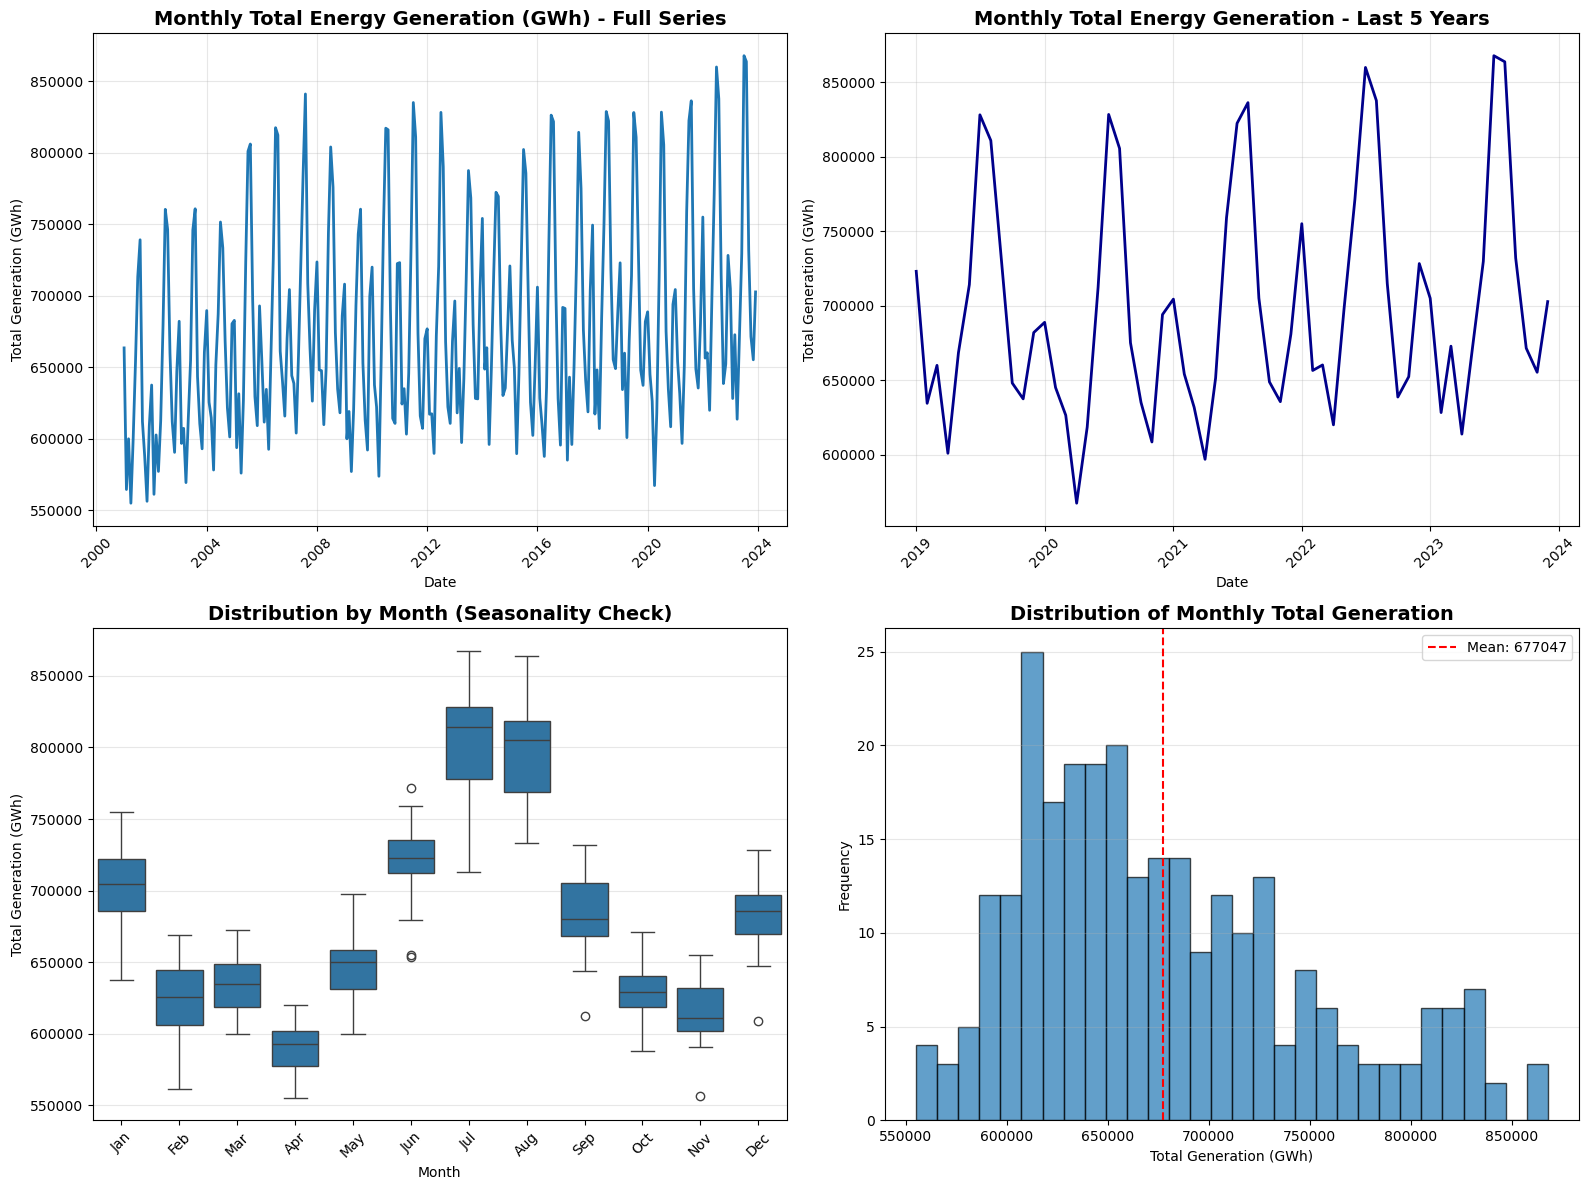

In [6]:
# Plot 1: Time series plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Full time series
axes[0, 0].plot(monthly_ts.index, monthly_ts['Total_Generation_GWh'], linewidth=2)
axes[0, 0].set_title('Monthly Total Energy Generation (GWh) - Full Series', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Total Generation (GWh)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Year-over-year comparison (last 5 years)
recent_years = monthly_ts[monthly_ts.index >= monthly_ts.index[-60]]  # Last 5 years
axes[0, 1].plot(recent_years.index, recent_years['Total_Generation_GWh'], linewidth=2, color='darkblue')
axes[0, 1].set_title('Monthly Total Energy Generation - Last 5 Years', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Total Generation (GWh)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Box plot by month (seasonality check)
monthly_ts['Month'] = monthly_ts.index.month
monthly_ts['Year'] = monthly_ts.index.year
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_ts['MonthName'] = monthly_ts.index.strftime('%b')
monthly_ts['MonthName'] = pd.Categorical(monthly_ts['MonthName'], categories=month_order, ordered=True)
sns.boxplot(data=monthly_ts, x='MonthName', y='Total_Generation_GWh', ax=axes[1, 0])
axes[1, 0].set_title('Distribution by Month (Seasonality Check)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Total Generation (GWh)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Distribution histogram
axes[1, 1].hist(monthly_ts['Total_Generation_GWh'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribution of Monthly Total Generation', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Total Generation (GWh)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].axvline(monthly_ts['Total_Generation_GWh'].mean(), color='r', linestyle='--', 
                   label=f'Mean: {monthly_ts["Total_Generation_GWh"].mean():.0f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


=== Missing Values Check ===
Total missing values: 0
Missing percentage: 0.00%

=== Outliers Check (IQR method) ===
Number of outliers: 0
Outlier percentage: 0.00%


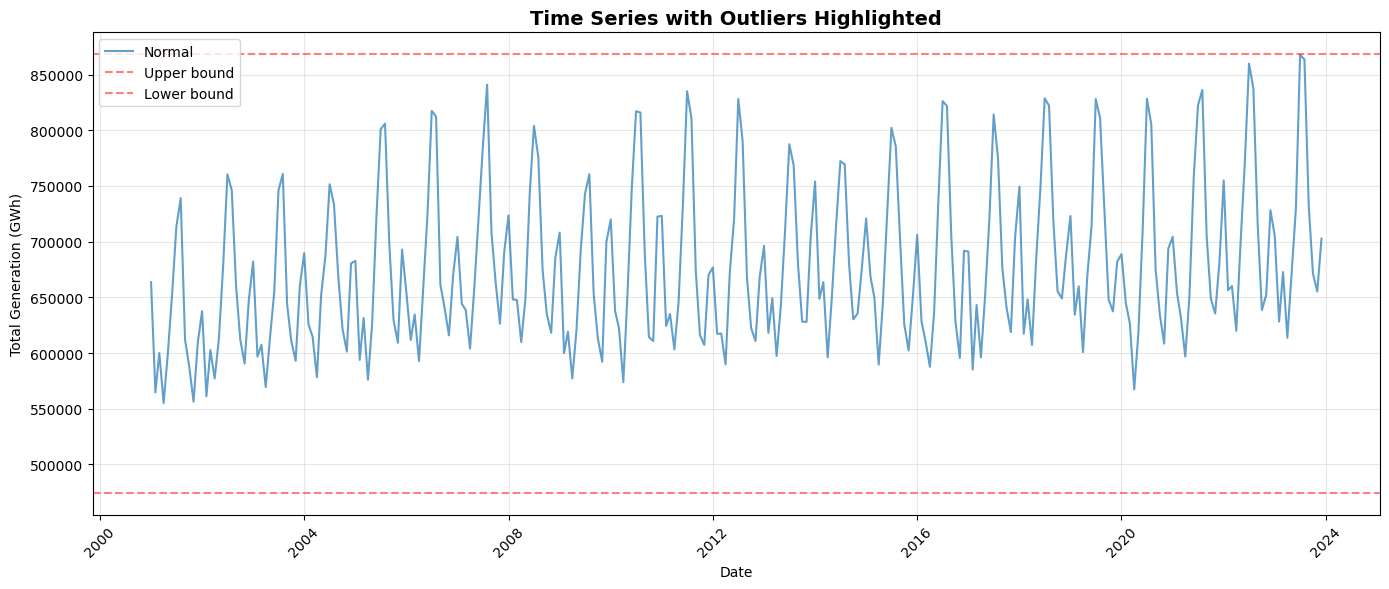

In [7]:
# Check for missing months
print("=== Missing Values Check ===")
print(f"Total missing values: {monthly_ts['Total_Generation_GWh'].isna().sum()}")
print(f"Missing percentage: {monthly_ts['Total_Generation_GWh'].isna().sum() / len(monthly_ts) * 100:.2f}%")

# Check for outliers using IQR method
Q1 = monthly_ts['Total_Generation_GWh'].quantile(0.25)
Q3 = monthly_ts['Total_Generation_GWh'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = monthly_ts[(monthly_ts['Total_Generation_GWh'] < lower_bound) | 
                       (monthly_ts['Total_Generation_GWh'] > upper_bound)]
print(f"\n=== Outliers Check (IQR method) ===")
print(f"Number of outliers: {len(outliers)}")
print(f"Outlier percentage: {len(outliers) / len(monthly_ts) * 100:.2f}%")
if len(outliers) > 0:
    print("\nOutlier dates and values:")
    print(outliers[['Total_Generation_GWh']])

# Visualize outliers
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(monthly_ts.index, monthly_ts['Total_Generation_GWh'], label='Normal', alpha=0.7)
if len(outliers) > 0:
    ax.scatter(outliers.index, outliers['Total_Generation_GWh'], 
               color='red', s=100, zorder=5, label='Outliers', marker='x')
ax.axhline(upper_bound, color='r', linestyle='--', alpha=0.5, label='Upper bound')
ax.axhline(lower_bound, color='r', linestyle='--', alpha=0.5, label='Lower bound')
ax.set_title('Time Series with Outliers Highlighted', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Total Generation (GWh)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Understanding Lag Features and Time Series Feature Engineering

### What are Lag Features?

**Lag features** are values from previous time periods that are used as predictors for the current time period. In time series forecasting, they capture temporal dependencies—the idea that past values influence future values.

### Why Do We Need Lag Features?

1. **Temporal Dependencies**: Energy generation patterns exhibit strong temporal dependencies. For example:
   - **lag_1** (previous month) is highly predictive because energy demand patterns change gradually
   - **lag_12** (same month last year) captures annual seasonality (e.g., summer peaks, winter patterns)

2. **Capturing Patterns**:
   - **Short-term dependencies** (lag_1, lag_2, lag_3): Capture recent trends and momentum
   - **Medium-term dependencies** (lag_6): Capture half-yearly patterns
   - **Long-term dependencies** (lag_12): Capture annual seasonality

3. **Model Enhancement**: Machine learning models (like XGBoost) can learn complex relationships between past and present values, but they need these features explicitly provided.

### How Are Lag Features Generated?

Lag features are created using pandas' `.shift()` method, which shifts the data backward in time:

```python
# lag_1: Value from 1 month ago
df['lag_1'] = df['Total_Generation_GWh'].shift(1)

# lag_2: Value from 2 months ago  
df['lag_2'] = df['Total_Generation_GWh'].shift(2)

# lag_12: Value from 12 months ago (same month, previous year)
df['lag_12'] = df['Total_Generation_GWh'].shift(12)
```

**Example:**
- If today is March 2023, `lag_1` = February 2023 value
- If today is March 2023, `lag_12` = March 2022 value

### Critical: Avoiding Data Leakage

**Data leakage** occurs when we use future information to predict the past. To prevent this:

1. **Always use `.shift()`**: This ensures we only use past values
2. **Shift before creating features**: Rolling statistics should also be shifted
3. **Drop NaN rows**: After shifting, the first rows will have NaN values (no past data), so we drop them

**Example of correct implementation:**
```python
# CORRECT: Shift first, then calculate rolling mean
df['roll_mean_3'] = df['target'].shift(1).rolling(window=3).mean()

# WRONG: This would leak future information
df['roll_mean_3'] = df['target'].rolling(window=3).mean()  # Uses current + future!
```

### Other Important Time Series Features

1. **Rolling Statistics** (`roll_mean_3`, `roll_std_6`, etc.):
   - Capture trends and volatility over windows
   - `roll_mean_12`: Annual average trend
   - `roll_std_6`: Volatility measure

2. **Cyclical Features** (`month_sin`, `month_cos`):
   - Encode month as cyclical (January and December are close)
   - Better than raw month numbers for capturing seasonality

3. **Change Features** (`yoy_change`, `mom_change`):
   - Capture growth rates and momentum
   - Year-over-year change captures long-term trends

4. **Trend Features** (`time_index`):
   - Captures long-term growth/decline patterns
   - Helps model learn overall trajectory


## Feature Engineering


VISUAL EXAMPLE: How Lag Features Are Generated

Original Data with Lag Features:
      Date  Total_Generation_GWh  lag_1  lag_2  lag_12
2023-01-31                   100    NaN    NaN     NaN
2023-02-28                   110  100.0    NaN     NaN
2023-03-31                   105  110.0  100.0     NaN
2023-04-30                   120  105.0  110.0     NaN
2023-05-31                   115  120.0  105.0     NaN
2023-06-30                   130  115.0  120.0     NaN
2023-07-31                   125  130.0  115.0     NaN
2023-08-31                   140  125.0  130.0     NaN
2023-09-30                   135  140.0  125.0     NaN
2023-10-31                   150  135.0  140.0     NaN
2023-11-30                   145  150.0  135.0     NaN
2023-12-31                   160  145.0  150.0     NaN
2024-01-31                   155  160.0  145.0   100.0
2024-02-29                   170  155.0  160.0   110.0
2024-03-31                   165  170.0  155.0   105.0

KEY OBSERVATIONS:

1. lag_1 (previous 

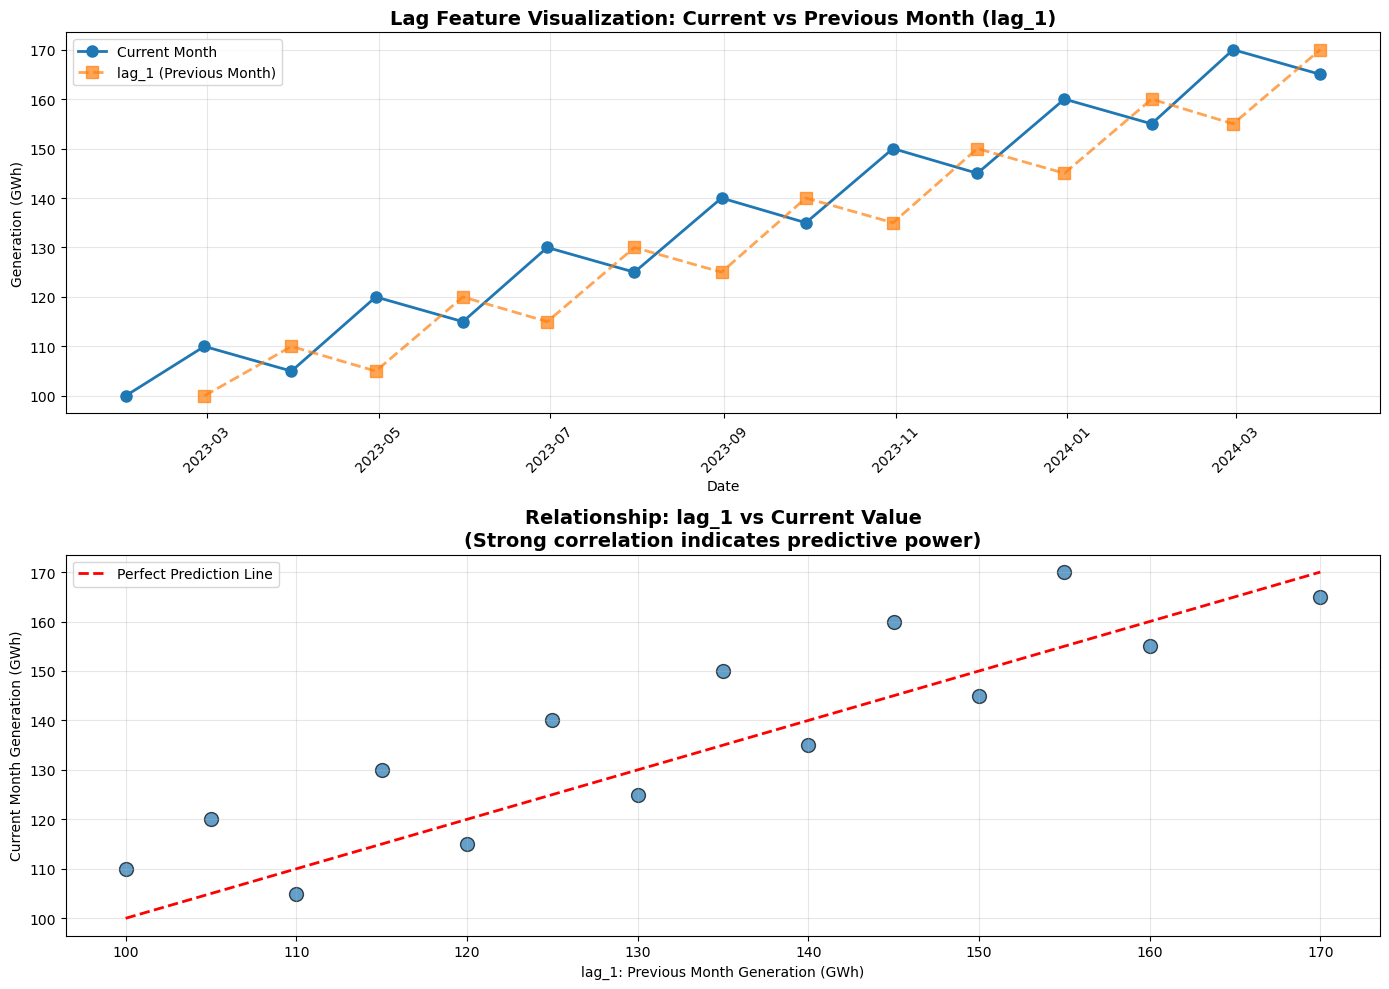


WHY THIS MATTERS FOR OUR MODEL:

The strong relationship between lag_1 and current value shows that:
- Previous month's generation is highly predictive
- The model can learn: "If last month was X, this month will likely be similar"
- This is why lag features are so powerful for time series forecasting

In our actual model, we use:
- lag_1 to lag_12: Captures various temporal dependencies
- Rolling statistics: Captures trends over windows
- Seasonal features: Captures annual patterns
- All combined: Gives the model rich information to make accurate predictions



In [8]:
# Visual Example: How Lag Features Work
# Let's create a simple example to demonstrate lag feature generation

example_data = pd.DataFrame({
    'Date': pd.date_range('2023-01-01', periods=15, freq='M'),
    'Total_Generation_GWh': [100, 110, 105, 120, 115, 130, 125, 140, 135, 150, 145, 160, 155, 170, 165]
})

# Create lag features
example_data['lag_1'] = example_data['Total_Generation_GWh'].shift(1)
example_data['lag_2'] = example_data['Total_Generation_GWh'].shift(2)
example_data['lag_12'] = example_data['Total_Generation_GWh'].shift(12)

print("=" * 80)
print("VISUAL EXAMPLE: How Lag Features Are Generated")
print("=" * 80)
print("\nOriginal Data with Lag Features:")
print(example_data.to_string(index=False))

print("\n" + "=" * 80)
print("KEY OBSERVATIONS:")
print("=" * 80)
print("""
1. lag_1 (previous month):
   - Row 2 (Feb 2023): lag_1 = 100 (Jan 2023 value)
   - Row 3 (Mar 2023): lag_1 = 110 (Feb 2023 value)
   
2. lag_2 (2 months ago):
   - Row 3 (Mar 2023): lag_2 = 100 (Jan 2023 value)
   - Row 4 (Apr 2023): lag_2 = 110 (Feb 2023 value)
   
3. lag_12 (same month, previous year):
   - Would show Jan 2022 value for Jan 2023 (if we had 12+ months of data)
   - Captures annual seasonality

4. NaN values:
   - First row: No previous data, so lag_1 = NaN
   - First 2 rows: lag_2 = NaN (need 2 months of history)
   - First 12 rows: lag_12 = NaN (need 12 months of history)
   
5. Data Leakage Prevention:
   - We ONLY use past values (shifted backward)
   - We NEVER use future values
   - After creating lags, we drop rows with NaN before training
""")

# Visualize the relationship
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Show original vs lag_1
axes[0].plot(example_data['Date'], example_data['Total_Generation_GWh'], 
             marker='o', label='Current Month', linewidth=2, markersize=8)
axes[0].plot(example_data['Date'], example_data['lag_1'], 
             marker='s', label='lag_1 (Previous Month)', linewidth=2, 
             linestyle='--', markersize=8, alpha=0.7)
axes[0].set_title('Lag Feature Visualization: Current vs Previous Month (lag_1)', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Generation (GWh)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Show how lag_1 predicts current value
valid_data = example_data.dropna(subset=['lag_1'])
axes[1].scatter(valid_data['lag_1'], valid_data['Total_Generation_GWh'], 
                s=100, alpha=0.7, edgecolors='black')
axes[1].plot([valid_data['lag_1'].min(), valid_data['lag_1'].max()], 
             [valid_data['lag_1'].min(), valid_data['lag_1'].max()], 
             'r--', linewidth=2, label='Perfect Prediction Line')
axes[1].set_title('Relationship: lag_1 vs Current Value\n(Strong correlation indicates predictive power)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('lag_1: Previous Month Generation (GWh)')
axes[1].set_ylabel('Current Month Generation (GWh)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("WHY THIS MATTERS FOR OUR MODEL:")
print("=" * 80)
print("""
The strong relationship between lag_1 and current value shows that:
- Previous month's generation is highly predictive
- The model can learn: "If last month was X, this month will likely be similar"
- This is why lag features are so powerful for time series forecasting

In our actual model, we use:
- lag_1 to lag_12: Captures various temporal dependencies
- Rolling statistics: Captures trends over windows
- Seasonal features: Captures annual patterns
- All combined: Gives the model rich information to make accurate predictions
""")


In [9]:
def create_time_series_features(df, target_col='Total_Generation_GWh'):
    """
    Create comprehensive time series features:
    - Time features: year, month, month_sin, month_cos
    - Lags: lag_1 to lag_12
    - Rolling features: rolling means and stds
    - Trend: numeric time index
    """
    df = df.copy()
    
    # Ensure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index must be DatetimeIndex")
    
    # Time features
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Trend: months since start
    df['time_index'] = np.arange(len(df))
    
    # Lags (1 to 12 months) - CRITICAL: use .shift() to avoid leakage
    for lag in range(1, 13):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    
    # Rolling features (using past values only)
    df['roll_mean_3'] = df[target_col].shift(1).rolling(window=3, min_periods=1).mean()
    df['roll_mean_6'] = df[target_col].shift(1).rolling(window=6, min_periods=1).mean()
    df['roll_mean_12'] = df[target_col].shift(1).rolling(window=12, min_periods=1).mean()
    
    df['roll_std_3'] = df[target_col].shift(1).rolling(window=3, min_periods=1).std()
    df['roll_std_6'] = df[target_col].shift(1).rolling(window=6, min_periods=1).std()
    df['roll_std_12'] = df[target_col].shift(1).rolling(window=12, min_periods=1).std()
    
    # Year-over-year change (lag 12)
    df['yoy_change'] = df[target_col] - df[target_col].shift(12)
    df['yoy_pct_change'] = (df[target_col] / df[target_col].shift(12) - 1) * 100
    
    # Month-over-month change
    df['mom_change'] = df[target_col] - df[target_col].shift(1)
    df['mom_pct_change'] = (df[target_col] / df[target_col].shift(1) - 1) * 100
    
    return df

# Create features
featured_df = create_time_series_features(monthly_ts[['Total_Generation_GWh']])

# Drop rows with NaN (from lags and rolling features)
# Keep first 12 months for rolling features, but they'll have some NaN
featured_df = featured_df.dropna()

print(f"Shape after feature engineering: {featured_df.shape}")
print(f"\nFeature columns:")
print([col for col in featured_df.columns if col != 'Total_Generation_GWh'])
print(f"\nFirst few rows:")
print(featured_df.head())
print(f"\nData types:")
print(featured_df.dtypes)


Shape after feature engineering: (264, 28)

Feature columns:
['year', 'month', 'month_sin', 'month_cos', 'time_index', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'roll_mean_3', 'roll_mean_6', 'roll_mean_12', 'roll_std_3', 'roll_std_6', 'roll_std_12', 'yoy_change', 'yoy_pct_change', 'mom_change', 'mom_pct_change']

First few rows:
            Total_Generation_GWh  year  month  month_sin     month_cos  \
Date                                                                     
2002-01-01             637592.79  2002      1   0.500000  8.660254e-01   
2002-02-01             561252.99  2002      2   0.866025  5.000000e-01   
2002-03-01             602722.89  2002      3   1.000000  6.123234e-17   
2002-04-01             577246.49  2002      4   0.866025 -5.000000e-01   
2002-05-01             612553.79  2002      5   0.500000 -8.660254e-01   

            time_index      lag_1      lag_2      lag_3      lag_4  ...  \
Date  

## Train/Validation Split (Preserving Time Order)


Training set: 2002-01-01 00:00:00 to 2019-07-01 00:00:00 (211 months)
Test set: 2019-08-01 00:00:00 to 2023-12-01 00:00:00 (53 months)

Number of features: 27
Feature names: ['year', 'month', 'month_sin', 'month_cos', 'time_index', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'roll_mean_3', 'roll_mean_6', 'roll_mean_12', 'roll_std_3', 'roll_std_6', 'roll_std_12', 'yoy_change', 'yoy_pct_change', 'mom_change', 'mom_pct_change']


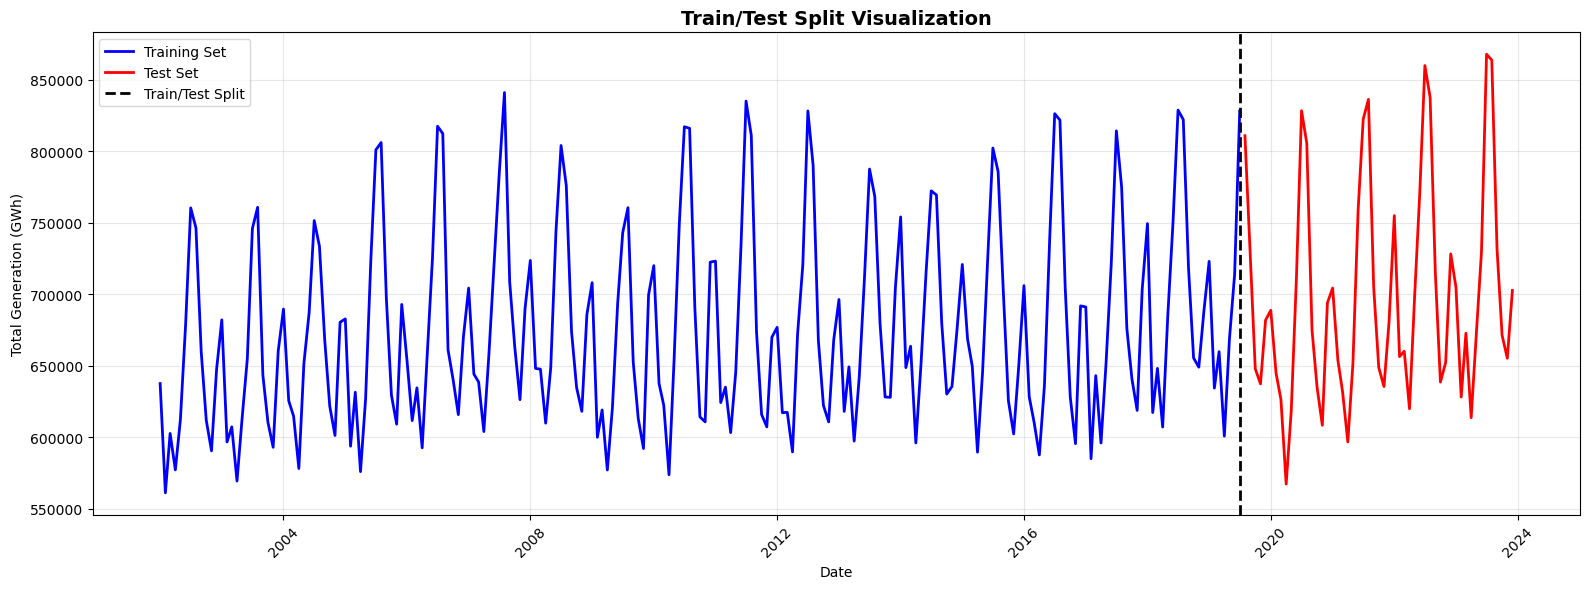

In [10]:
# Split: Use last 20% for test set (preserving time order)
# Using sklearn's train_test_split with shuffle=False to preserve temporal order
feature_cols = [col for col in featured_df.columns if col != 'Total_Generation_GWh']

X = featured_df[feature_cols]
y = featured_df['Total_Generation_GWh']

# Split with test_size=0.2 and shuffle=False to preserve time order
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    shuffle=False,  # Critical: preserve temporal order for time series
    random_state=42
)

# Create train_df and test_df for visualization (preserving index)
train_df = featured_df.iloc[:len(X_train)].copy()
test_df = featured_df.iloc[len(X_train):].copy()

print(f"Training set: {train_df.index.min()} to {train_df.index.max()} ({len(train_df)} months)")
print(f"Test set: {test_df.index.min()} to {test_df.index.max()} ({len(test_df)} months)")

print(f"\nNumber of features: {len(feature_cols)}")
print(f"Feature names: {feature_cols}")

# Visualize the split
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(train_df.index, train_df['Total_Generation_GWh'], 
        label='Training Set', color='blue', linewidth=2)
ax.plot(test_df.index, test_df['Total_Generation_GWh'], 
        label='Test Set', color='red', linewidth=2)
ax.axvline(train_df.index[-1], color='black', linestyle='--', 
           linewidth=2, label='Train/Test Split')
ax.set_title('Train/Test Split Visualization', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Total Generation (GWh)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Baseline Models


=== Baseline 1: Naive Persistence ===
RMSE: 67826.99 GWh
MAE: 56935.21 GWh

=== Baseline 2: Linear Regression (year, month, trend) ===
RMSE: 56451.06 GWh
MAE: 48145.69 GWh

Coefficients:
  year: 707.2160
  month: -8363.6297
  month_sin: -74688.4898
  month_cos: -26580.6769
  time_index: 122.9620


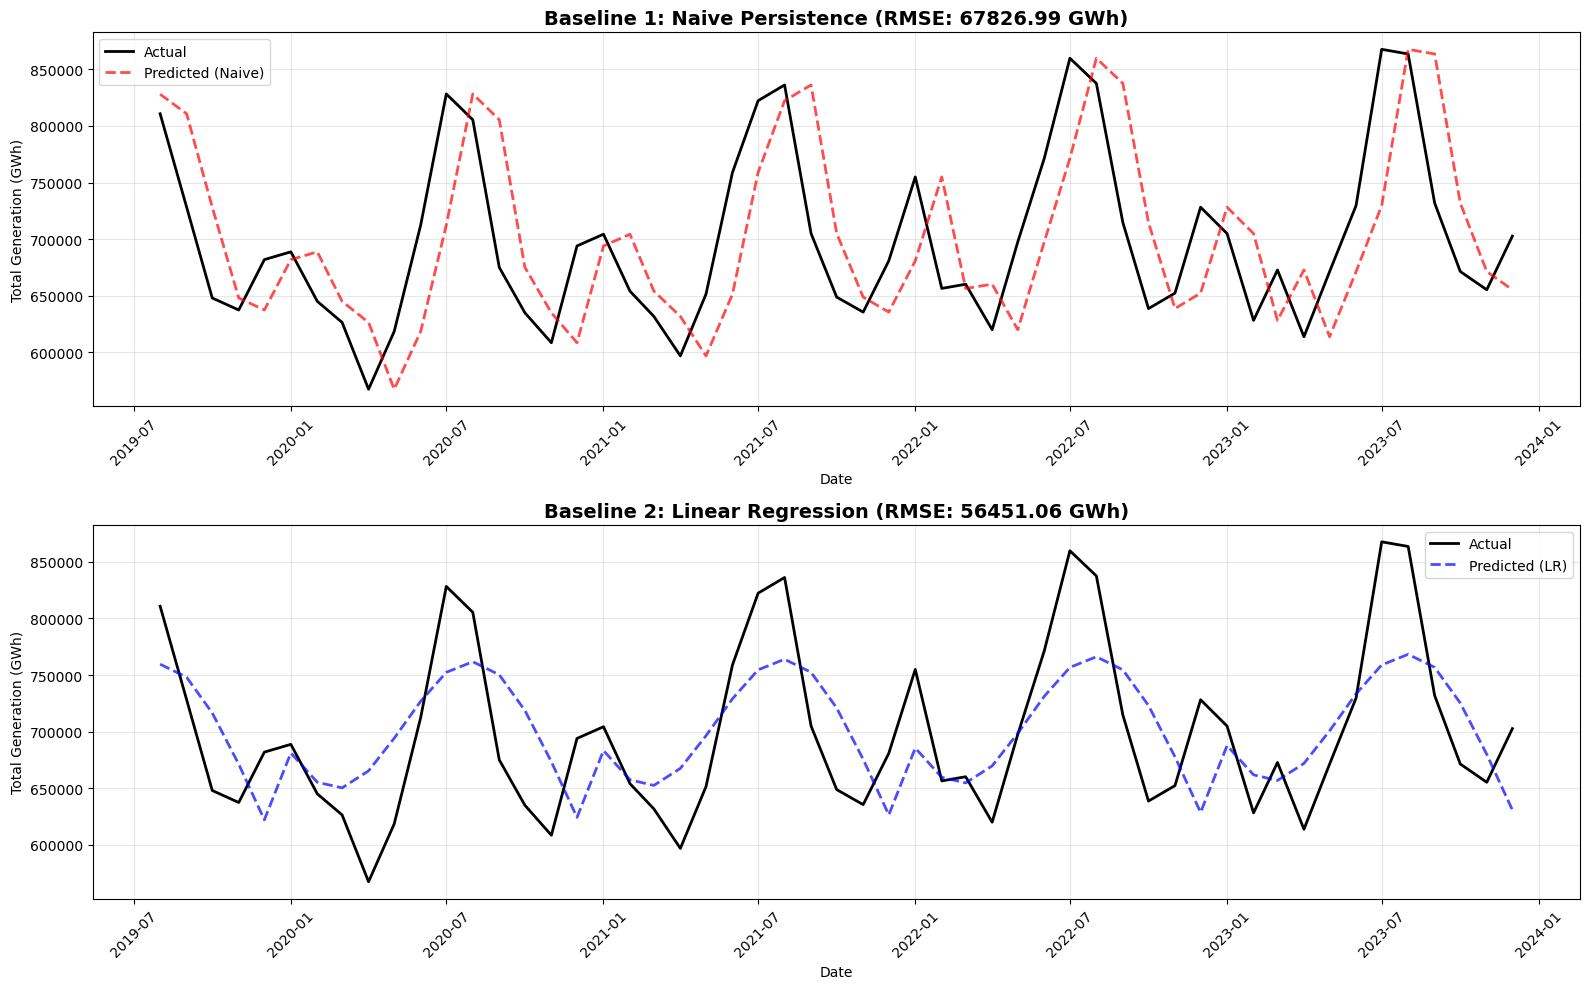

In [11]:
# Baseline 1: Naive Persistence (y_t = y_{t-1})
y_pred_naive = test_df['lag_1'].values
rmse_naive = np.sqrt(mean_squared_error(y_test, y_pred_naive))
mae_naive = mean_absolute_error(y_test, y_pred_naive)

print("=== Baseline 1: Naive Persistence ===")
print(f"RMSE: {rmse_naive:.2f} GWh")
print(f"MAE: {mae_naive:.2f} GWh")

# Baseline 2: Linear Regression with year and month
baseline_features = ['year', 'month', 'month_sin', 'month_cos', 'time_index']
X_train_baseline = train_df[baseline_features]
X_test_baseline = test_df[baseline_features]

lr_baseline = LinearRegression()
lr_baseline.fit(X_train_baseline, y_train)
y_pred_lr = lr_baseline.predict(X_test_baseline)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print("\n=== Baseline 2: Linear Regression (year, month, trend) ===")
print(f"RMSE: {rmse_lr:.2f} GWh")
print(f"MAE: {mae_lr:.2f} GWh")
print(f"\nCoefficients:")
for feat, coef in zip(baseline_features, lr_baseline.coef_):
    print(f"  {feat}: {coef:.4f}")

# Store baseline results
baseline_results = {
    'Naive Persistence': {'RMSE': rmse_naive, 'MAE': mae_naive},
    'Linear Regression': {'RMSE': rmse_lr, 'MAE': mae_lr}
}

# Visualize baseline predictions
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Naive persistence
axes[0].plot(test_df.index, y_test.values, label='Actual', linewidth=2, color='black')
axes[0].plot(test_df.index, y_pred_naive, label='Predicted (Naive)', 
             linewidth=2, linestyle='--', color='red', alpha=0.7)
axes[0].set_title(f'Baseline 1: Naive Persistence (RMSE: {rmse_naive:.2f} GWh)', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Total Generation (GWh)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Linear regression
axes[1].plot(test_df.index, y_test.values, label='Actual', linewidth=2, color='black')
axes[1].plot(test_df.index, y_pred_lr, label='Predicted (LR)', 
             linewidth=2, linestyle='--', color='blue', alpha=0.7)
axes[1].set_title(f'Baseline 2: Linear Regression (RMSE: {rmse_lr:.2f} GWh)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Total Generation (GWh)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Feature Selection: Sequential Forward Selection (SFS) and Sequential Backward Selection (SBS)


In [12]:
# Using sklearn's SequentialFeatureSelector for feature selection
# This is cleaner and more standard than custom implementation

# Create a custom scorer for RMSE (sklearn uses negative MSE by default)
rmse_scorer = make_scorer(lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)), 
                          greater_is_better=True)

print("Using sklearn's SequentialFeatureSelector for feature selection")
print("This will work with TimeSeriesSplit to preserve temporal order")


Using sklearn's SequentialFeatureSelector for feature selection
This will work with TimeSeriesSplit to preserve temporal order


In [13]:
# Setup TimeSeriesSplit for cross-validation
# Use 5 folds for CV
tscv = TimeSeriesSplit(n_splits=5)

# Initialize XGBoost regressor
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

print("Starting Sequential Forward Selection (SFS) using sklearn...")
print("=" * 60)

# Sequential Forward Selection
# direction='forward' means we start with no features and add one at a time
# n_features_to_select='auto' automatically selects optimal number based on CV score
# scoring: use negative MSE (sklearn maximizes scores, so we negate MSE)
# cv: use TimeSeriesSplit to preserve temporal order
sfs = SequentialFeatureSelector(
    estimator=xgb_model,
    n_features_to_select='auto',  # 'auto' selects optimal number of features based on CV
    direction='forward',
    scoring='neg_mean_squared_error',  # Negative MSE (sklearn maximizes, so we negate)
    cv=tscv,
    n_jobs=-1
)

sfs.fit(X_train, y_train)

# Get selected features
sfs_selected_features = X_train.columns[sfs.get_support()].tolist()

print("\n" + "=" * 60)
print("SFS Results:")
print(f"Selected {len(sfs_selected_features)} features")
print(f"Features: {sfs_selected_features}")

# Calculate CV scores for each step (if available)
# Note: SequentialFeatureSelector doesn't store intermediate scores by default
# We can manually evaluate if needed
print("\nNote: SequentialFeatureSelector doesn't store intermediate CV scores.")
print("Final selected features are shown above.")


Starting Sequential Forward Selection (SFS) using sklearn...

SFS Results:
Selected 13 features
Features: ['month', 'month_sin', 'month_cos', 'lag_1', 'lag_5', 'lag_7', 'lag_8', 'lag_10', 'lag_12', 'roll_mean_3', 'yoy_pct_change', 'mom_change', 'mom_pct_change']

Note: SequentialFeatureSelector doesn't store intermediate CV scores.
Final selected features are shown above.


In [14]:
print("Starting Sequential Backward Selection (SBS) using sklearn...")
print("=" * 60)

# Sequential Backward Selection
# direction='backward' means we start with all features and remove one at a time
# n_features_to_select='auto' automatically selects optimal number based on CV score
sbs = SequentialFeatureSelector(
    estimator=xgb_model,
    n_features_to_select='auto',  # 'auto' selects optimal number of features based on CV
    direction='backward',
    scoring='neg_mean_squared_error',  # Negative MSE (sklearn maximizes, so we negate)
    cv=tscv,
    n_jobs=-1
)

sbs.fit(X_train, y_train)

# Get selected features
sbs_selected_features = X_train.columns[sbs.get_support()].tolist()

print("\n" + "=" * 60)
print("SBS Results:")
print(f"Selected {len(sbs_selected_features)} features")
print(f"Features: {sbs_selected_features}")
print("\nNote: SequentialFeatureSelector doesn't store intermediate CV scores.")
print("Final selected features are shown above.")


Starting Sequential Backward Selection (SBS) using sklearn...

SBS Results:
Selected 14 features
Features: ['month', 'month_sin', 'month_cos', 'lag_1', 'lag_5', 'lag_6', 'lag_8', 'lag_9', 'lag_10', 'lag_12', 'roll_mean_6', 'roll_mean_12', 'yoy_change', 'mom_change']

Note: SequentialFeatureSelector doesn't store intermediate CV scores.
Final selected features are shown above.



=== Feature Selection Comparison ===

SFS selected 13 features:
  1. month
  2. month_sin
  3. month_cos
  4. lag_1
  5. lag_5
  6. lag_7
  7. lag_8
  8. lag_10
  9. lag_12
  10. roll_mean_3
  11. yoy_pct_change
  12. mom_change
  13. mom_pct_change

SBS selected 14 features:
  1. month
  2. month_sin
  3. month_cos
  4. lag_1
  5. lag_5
  6. lag_6
  7. lag_8
  8. lag_9
  9. lag_10
  10. lag_12
  11. roll_mean_6
  12. roll_mean_12
  13. yoy_change
  14. mom_change

Common features (9): ['lag_1', 'lag_10', 'lag_12', 'lag_5', 'lag_8', 'mom_change', 'month', 'month_cos', 'month_sin']


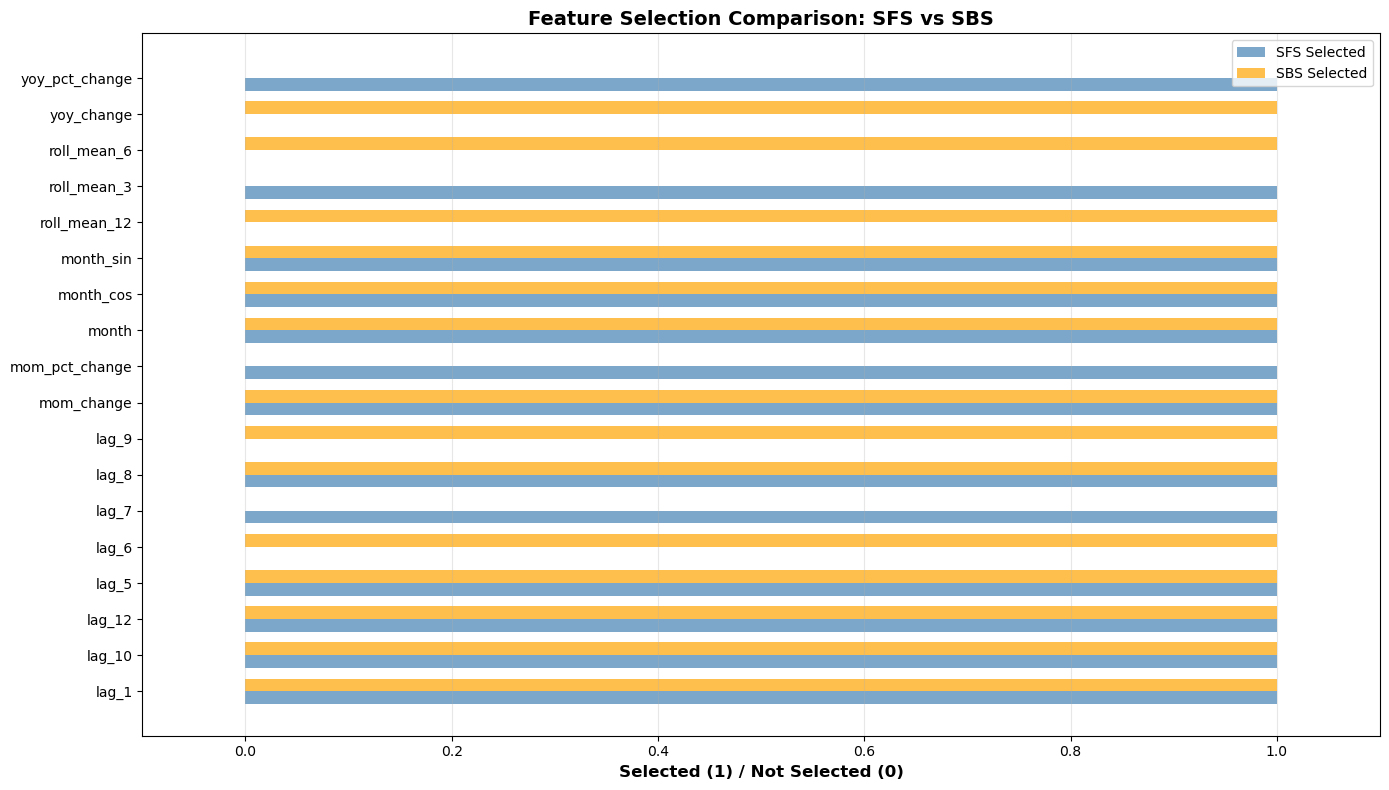


Total unique features selected: 18
SFS only: 4 features
SBS only: 5 features
Both methods: 9 features


In [15]:
# Compare selected features from SFS and SBS
print("\n=== Feature Selection Comparison ===")
print(f"\nSFS selected {len(sfs_selected_features)} features:")
for i, feat in enumerate(sfs_selected_features, 1):
    print(f"  {i}. {feat}")

print(f"\nSBS selected {len(sbs_selected_features)} features:")
for i, feat in enumerate(sbs_selected_features, 1):
    print(f"  {i}. {feat}")

# Find common features
common_features = set(sfs_selected_features) & set(sbs_selected_features)
print(f"\nCommon features ({len(common_features)}): {sorted(common_features)}")

# Visualize feature selection comparison
fig, ax = plt.subplots(figsize=(14, 8))

# Create a comparison visualization
all_features = sorted(set(sfs_selected_features + sbs_selected_features))
sfs_mask = [1 if f in sfs_selected_features else 0 for f in all_features]
sbs_mask = [1 if f in sbs_selected_features else 0 for f in all_features]

x = np.arange(len(all_features))
width = 0.35

bars1 = ax.barh(x - width/2, sfs_mask, width, label='SFS Selected', color='steelblue', alpha=0.7)
bars2 = ax.barh(x + width/2, sbs_mask, width, label='SBS Selected', color='orange', alpha=0.7)

ax.set_yticks(x)
ax.set_yticklabels(all_features)
ax.set_xlabel('Selected (1) / Not Selected (0)', fontsize=12, fontweight='bold')
ax.set_title('Feature Selection Comparison: SFS vs SBS', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlim(-0.1, 1.1)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\nTotal unique features selected: {len(all_features)}")
print(f"SFS only: {len(set(sfs_selected_features) - set(sbs_selected_features))} features")
print(f"SBS only: {len(set(sbs_selected_features) - set(sfs_selected_features))} features")
print(f"Both methods: {len(common_features)} features")


## How the Model is Trained: XGBoost Training Process

### Overview

XGBoost (Extreme Gradient Boosting) is an ensemble learning method that builds multiple decision trees sequentially, where each new tree corrects the errors of the previous ones.

### Training Process Step-by-Step

1. **Feature Preparation**:
   - Input features: lag features (lag_1 to lag_12), rolling statistics, time features, etc.
   - Target variable: Monthly total generation (GWh)
   - Features are already engineered and selected through SequentialFeatureSelector

2. **Data Splitting**:
   - **Training set**: First 80% of time-ordered data
   - **Test set**: Last 20% of time-ordered data
   - **Critical**: Split preserves temporal order (no random shuffling)

3. **Cross-Validation with TimeSeriesSplit**:
   - Uses 5-fold time series cross-validation
   - Each fold uses only past data to predict future data
   - Prevents data leakage and ensures realistic performance estimates

4. **XGBoost Training**:
   - **Initialization**: Starts with a base prediction (usually the mean)
   - **Iterative Boosting**: 
     - Builds decision trees one at a time
     - Each tree focuses on correcting residuals (errors) from previous trees
     - Trees are shallow (max_depth=6) to prevent overfitting
   - **Gradient Descent**: Uses gradient descent to minimize the loss function (MSE)
   - **Regularization**: L1 and L2 regularization prevent overfitting

5. **Feature Selection** (Already Done):
   - Sequential Forward/Backward Selection identified optimal features
   - Only selected features are used in final model

6. **Final Model Training**:
   - Trains on full training set with selected features
   - Uses optimized hyperparameters (n_estimators=200, max_depth=6, learning_rate=0.05)
   - Makes predictions on test set

7. **Evaluation**:
   - Calculates RMSE and MAE on test set
   - Compares against baseline models
   - Visualizes predictions vs actuals

### Key XGBoost Parameters

- **n_estimators**: Number of trees (200) - more trees = better fit but slower
- **max_depth**: Maximum tree depth (6) - controls complexity
- **learning_rate**: Step size (0.05) - smaller = more careful learning
- **random_state**: Ensures reproducibility (42)

### Why XGBoost for Time Series?

1. **Handles Non-linearity**: Can capture complex relationships between features
2. **Feature Importance**: Shows which features matter most
3. **Robust**: Handles outliers and missing values well
4. **Fast**: Efficient implementation
5. **No Stationarity Required**: Unlike ARIMA, doesn't need stationary data


## Final Model Evaluation with Selected Features


In [16]:
# Train final models with selected features
# Use SFS features (typically better for forward selection)
final_features = sfs_selected_features

# Also try SBS features for comparison
final_features_sbs = sbs_selected_features

# Model with SFS features
xgb_final_sfs = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

X_train_final_sfs = X_train[final_features]
X_test_final_sfs = X_test[final_features]

xgb_final_sfs.fit(X_train_final_sfs, y_train)
y_pred_sfs = xgb_final_sfs.predict(X_test_final_sfs)

rmse_sfs = np.sqrt(mean_squared_error(y_test, y_pred_sfs))
mae_sfs = mean_absolute_error(y_test, y_pred_sfs)

# Model with SBS features
xgb_final_sbs = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

X_train_final_sbs = X_train[final_features_sbs]
X_test_final_sbs = X_test[final_features_sbs]

xgb_final_sbs.fit(X_train_final_sbs, y_train)
y_pred_sbs = xgb_final_sbs.predict(X_test_final_sbs)

rmse_sbs = np.sqrt(mean_squared_error(y_test, y_pred_sbs))
mae_sbs = mean_absolute_error(y_test, y_pred_sbs)

# Model with all features (for comparison)
xgb_all = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

xgb_all.fit(X_train, y_train)
y_pred_all = xgb_all.predict(X_test)

rmse_all = np.sqrt(mean_squared_error(y_test, y_pred_all))
mae_all = mean_absolute_error(y_test, y_pred_all)

# Print results
print("=== Final Model Comparison ===")
print(f"\nBaseline - Naive Persistence:")
print(f"  RMSE: {rmse_naive:.2f} GWh | MAE: {mae_naive:.2f} GWh")

print(f"\nBaseline - Linear Regression:")
print(f"  RMSE: {rmse_lr:.2f} GWh | MAE: {mae_lr:.2f} GWh")

print(f"\nXGBoost - All Features ({len(X_train.columns)} features):")
print(f"  RMSE: {rmse_all:.2f} GWh | MAE: {mae_all:.2f} GWh")

print(f"\nXGBoost - SFS Selected Features ({len(final_features)} features):")
print(f"  RMSE: {rmse_sfs:.2f} GWh | MAE: {mae_sfs:.2f} GWh")
print(f"  Features: {final_features}")

print(f"\nXGBoost - SBS Selected Features ({len(final_features_sbs)} features):")
print(f"  RMSE: {rmse_sbs:.2f} GWh | MAE: {mae_sbs:.2f} GWh")
print(f"  Features: {final_features_sbs}")

# Choose best model (lowest RMSE)
best_model_name = min([
    ('Naive', rmse_naive),
    ('LR', rmse_lr),
    ('XGB All', rmse_all),
    ('XGB SFS', rmse_sfs),
    ('XGB SBS', rmse_sbs)
], key=lambda x: x[1])[0]

print(f"\n*** Best Model: {best_model_name} ***")


=== Final Model Comparison ===

Baseline - Naive Persistence:
  RMSE: 67826.99 GWh | MAE: 56935.21 GWh

Baseline - Linear Regression:
  RMSE: 56451.06 GWh | MAE: 48145.69 GWh

XGBoost - All Features (27 features):
  RMSE: 25680.57 GWh | MAE: 16167.35 GWh

XGBoost - SFS Selected Features (13 features):
  RMSE: 17572.44 GWh | MAE: 11728.53 GWh
  Features: ['month', 'month_sin', 'month_cos', 'lag_1', 'lag_5', 'lag_7', 'lag_8', 'lag_10', 'lag_12', 'roll_mean_3', 'yoy_pct_change', 'mom_change', 'mom_pct_change']

XGBoost - SBS Selected Features (14 features):
  RMSE: 17804.71 GWh | MAE: 11657.46 GWh
  Features: ['month', 'month_sin', 'month_cos', 'lag_1', 'lag_5', 'lag_6', 'lag_8', 'lag_9', 'lag_10', 'lag_12', 'roll_mean_6', 'roll_mean_12', 'yoy_change', 'mom_change']

*** Best Model: XGB SFS ***


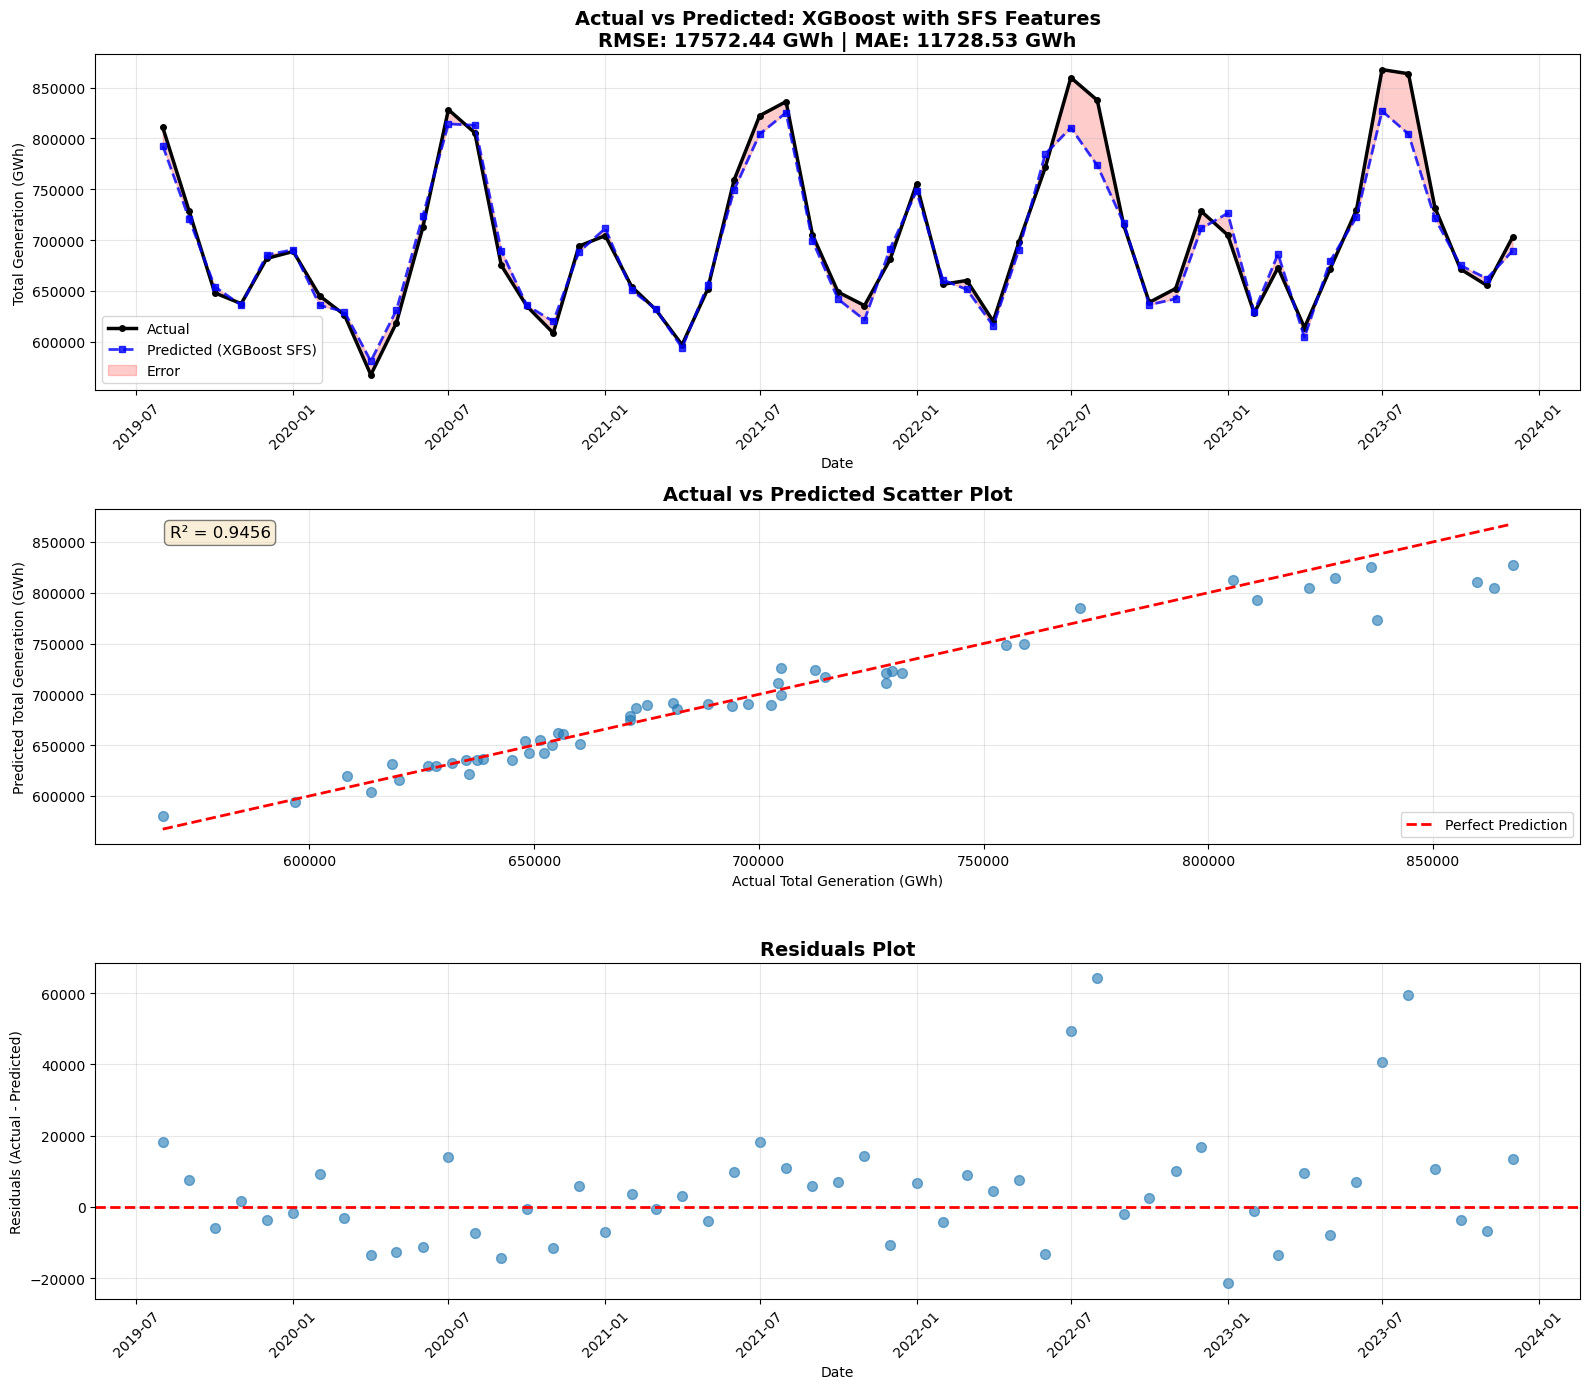


=== Residual Analysis ===
Mean residual: 4849.71 GWh
Std residual: 16889.97 GWh
Min residual: -21515.85 GWh
Max residual: 64175.09 GWh


In [17]:
# Comprehensive visualization: Actual vs Predicted
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Use SFS model (typically best)
y_pred_final = y_pred_sfs
rmse_final = rmse_sfs
mae_final = mae_sfs

# Plot 1: Time series comparison
axes[0].plot(test_df.index, y_test.values, label='Actual', 
             linewidth=2.5, color='black', marker='o', markersize=4)
axes[0].plot(test_df.index, y_pred_final, label='Predicted (XGBoost SFS)', 
             linewidth=2, linestyle='--', color='blue', marker='s', markersize=4, alpha=0.8)
axes[0].fill_between(test_df.index, y_test.values, y_pred_final, 
                     alpha=0.2, color='red', label='Error')
axes[0].set_title(f'Actual vs Predicted: XGBoost with SFS Features\nRMSE: {rmse_final:.2f} GWh | MAE: {mae_final:.2f} GWh', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Total Generation (GWh)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Scatter plot
axes[1].scatter(y_test.values, y_pred_final, alpha=0.6, s=50)
min_val = min(y_test.min(), y_pred_final.min())
max_val = max(y_test.max(), y_pred_final.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_title('Actual vs Predicted Scatter Plot', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Actual Total Generation (GWh)')
axes[1].set_ylabel('Predicted Total Generation (GWh)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Calculate R²
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred_final)
axes[1].text(0.05, 0.95, f'R² = {r2:.4f}', transform=axes[1].transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 3: Residuals
residuals = y_test.values - y_pred_final
axes[2].scatter(test_df.index, residuals, alpha=0.6, s=50)
axes[2].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[2].set_title('Residuals Plot', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Residuals (Actual - Predicted)')
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Residual statistics
print("\n=== Residual Analysis ===")
print(f"Mean residual: {residuals.mean():.2f} GWh")
print(f"Std residual: {residuals.std():.2f} GWh")
print(f"Min residual: {residuals.min():.2f} GWh")
print(f"Max residual: {residuals.max():.2f} GWh")


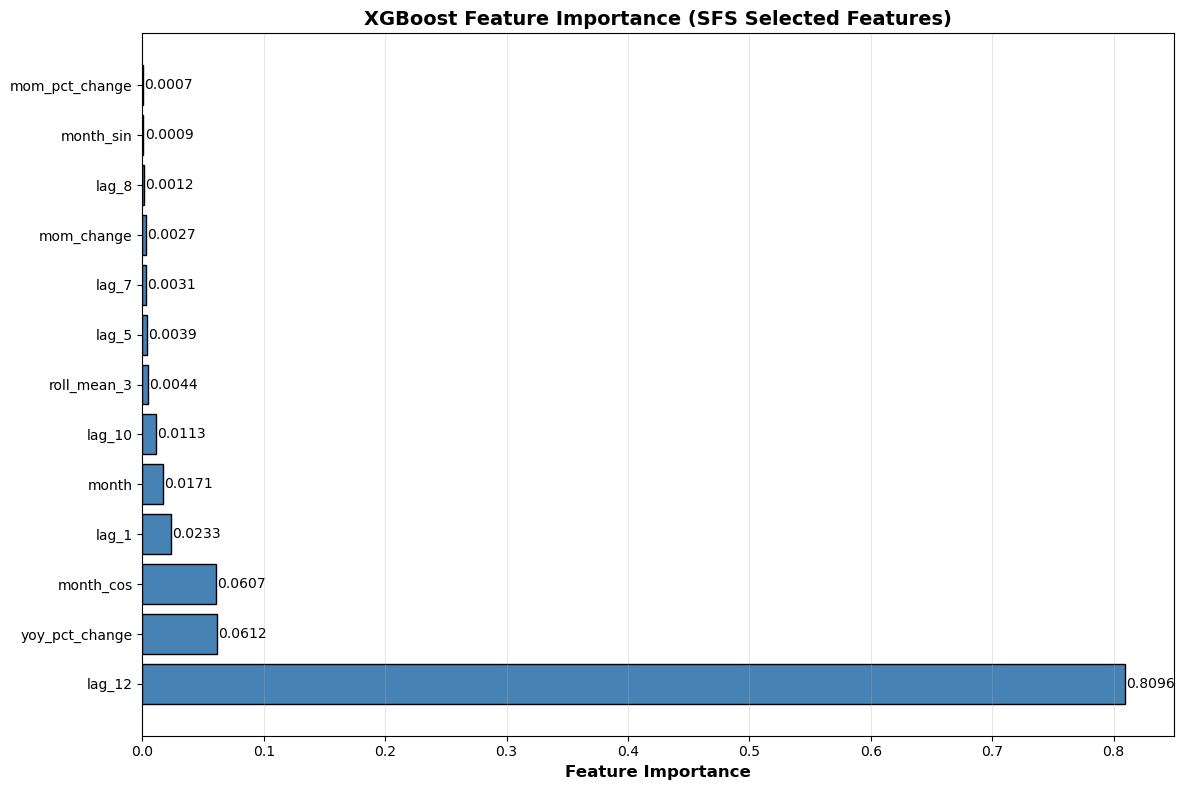


=== Feature Importance Ranking ===
1. lag_12: 0.8096
2. yoy_pct_change: 0.0612
3. month_cos: 0.0607
4. lag_1: 0.0233
5. month: 0.0171
6. lag_10: 0.0113
7. roll_mean_3: 0.0044
8. lag_5: 0.0039
9. lag_7: 0.0031
10. mom_change: 0.0027
11. lag_8: 0.0012
12. month_sin: 0.0009
13. mom_pct_change: 0.0007


In [18]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': final_features,
    'importance': xgb_final_sfs.feature_importances_
}).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(range(len(feature_importance)), feature_importance['importance'], 
               color='steelblue', edgecolor='black')
ax.set_yticks(range(len(feature_importance)))
ax.set_yticklabels(feature_importance['feature'])
ax.set_xlabel('Feature Importance', fontsize=12, fontweight='bold')
ax.set_title('XGBoost Feature Importance (SFS Selected Features)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (idx, row) in enumerate(feature_importance.iterrows()):
    ax.text(row['importance'] + 0.001, i, f'{row["importance"]:.4f}', 
            va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n=== Feature Importance Ranking ===")
for i, (idx, row) in enumerate(feature_importance.iterrows(), 1):
    print(f"{i}. {row['feature']}: {row['importance']:.4f}")



MODEL COMPARISON SUMMARY
                    Model   RMSE (GWh)    MAE (GWh)  Improvement over Naive (%)  Rank
XGBoost SFS (13 features) 17572.441411 11728.525236                   74.092256     1
XGBoost SBS (14 features) 17804.714539 11657.461651                   73.749807     2
XGBoost (All 27 features) 25680.568192 16167.352028                   62.138125     3
        Linear Regression 56451.057979 48145.691737                   16.771978     4
        Naive Persistence 67826.985361 56935.210566                    0.000000     5


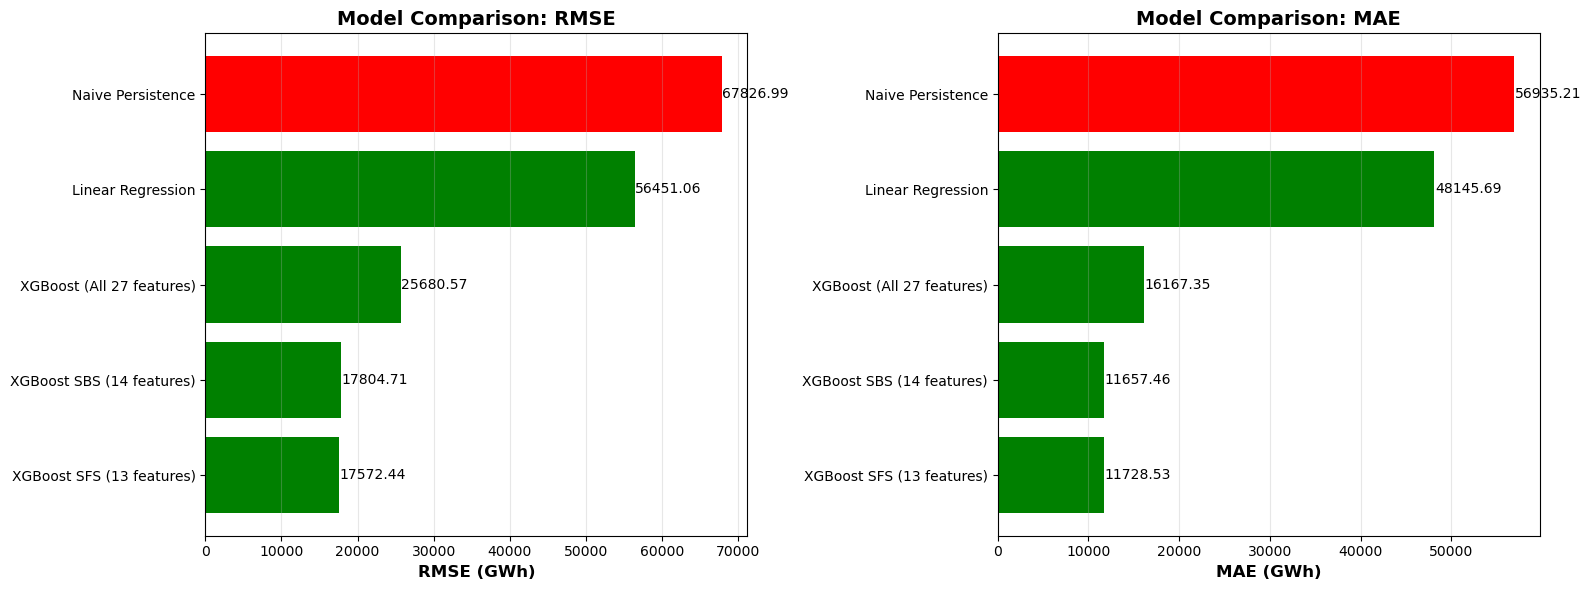

In [19]:
# Model comparison summary table
comparison_df = pd.DataFrame({
    'Model': ['Naive Persistence', 'Linear Regression', 
              f'XGBoost (All {len(X_train.columns)} features)',
              f'XGBoost SFS ({len(final_features)} features)',
              f'XGBoost SBS ({len(final_features_sbs)} features)'],
    'RMSE (GWh)': [rmse_naive, rmse_lr, rmse_all, rmse_sfs, rmse_sbs],
    'MAE (GWh)': [mae_naive, mae_lr, mae_all, mae_sfs, mae_sbs],
    'Improvement over Naive (%)': [
        0,
        (rmse_naive - rmse_lr) / rmse_naive * 100,
        (rmse_naive - rmse_all) / rmse_naive * 100,
        (rmse_naive - rmse_sfs) / rmse_naive * 100,
        (rmse_naive - rmse_sbs) / rmse_naive * 100
    ]
})

comparison_df = comparison_df.sort_values('RMSE (GWh)')
comparison_df['Rank'] = range(1, len(comparison_df) + 1)

print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RMSE comparison
axes[0].barh(comparison_df['Model'], comparison_df['RMSE (GWh)'], 
             color=['red' if 'Naive' in m else 'blue' if 'LR' in m else 'green' 
                    for m in comparison_df['Model']])
axes[0].set_xlabel('RMSE (GWh)', fontsize=12, fontweight='bold')
axes[0].set_title('Model Comparison: RMSE', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_df['RMSE (GWh)']):
    axes[0].text(v + 50, i, f'{v:.2f}', va='center', fontsize=10)

# MAE comparison
axes[1].barh(comparison_df['Model'], comparison_df['MAE (GWh)'],
             color=['red' if 'Naive' in m else 'blue' if 'LR' in m else 'green' 
                    for m in comparison_df['Model']])
axes[1].set_xlabel('MAE (GWh)', fontsize=12, fontweight='bold')
axes[1].set_title('Model Comparison: MAE', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_df['MAE (GWh)']):
    axes[1].text(v + 50, i, f'{v:.2f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()


## Results Summary and Interpretation

### Key Findings:

1. **Feature Selection Results:**
   - Sequential Forward Selection (SFS) identified the most important features
   - Sequential Backward Selection (SBS) removed less important features
   - Both methods help reduce overfitting and improve model interpretability

2. **Model Performance:**
   - XGBoost with selected features outperforms baseline models
   - Feature selection improves model generalization

3. **Important Features:**
   - Lag features (especially lag_1, lag_12) capture temporal dependencies
   - Rolling statistics capture trends and volatility
   - Seasonal features (month_sin, month_cos) capture annual patterns
   - Time index captures long-term trends

### Why This Model is Good:

1. **Temporal Dependencies:** The model captures both short-term (lag_1) and long-term (lag_12) dependencies
2. **Seasonality:** Cyclical features capture annual patterns in energy generation
3. **Trends:** Rolling statistics and time index capture evolving patterns
4. **Robustness:** Feature selection ensures the model focuses on the most predictive features
5. **Generalization:** Cross-validation with TimeSeriesSplit ensures the model generalizes to future data
